## Summary

----

## Imports

In [1]:
import os
import sys
import tempfile
import time
from collections import deque
from pathlib import Path

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyarrow
import torch
import torch.nn as nn
import tqdm
from matplotlib import cm
from torch_geometric.data import DataLoader

In [2]:
import proteinsolver
import proteinsolver.datasets

/dev/shm/env/lib/python3.7/site-packages/Bio/KDTree/__init__.py:25: BiopythonDeprecationWarning: Bio.KDTree has been deprecated, and we intend to remove it in a future release of Biopython. Please use Bio.PDB.kdtrees instead, which is functionally very similar.
  BiopythonDeprecationWarning)


In [3]:
%matplotlib inline

try:
    inline_rc
except NameError:
    inline_rc = mpl.rcParams.copy()
    
mpl.rcParams.update({"font.size": 12})

## Parameters

In [4]:
UNIQUE_ID = "94adb904"
UNIQUE_ID = "9236f2b7"
UNIQUE_ID = "4182ca3e"

In [5]:
DATA_ROOT = Path(tempfile.gettempdir())
DATA_ROOT.mkdir(exist_ok=True)
DATA_ROOT

PosixPath('/tmp')

In [6]:
NOTEBOOK_NAME = "sudoku_analysis"
NOTEBOOK_PATH = Path(NOTEBOOK_NAME)
NOTEBOOK_PATH.mkdir(exist_ok=True)
NOTEBOOK_PATH

PosixPath('sudoku_analysis')

In [7]:
DATAPKG_DATA_DIR = Path(f"~/datapkg_output_dir").expanduser().resolve()
DATAPKG_DATA_DIR

PosixPath('/scratch/strokach/datapkg_output_dir')

In [8]:
proteinsolver.settings.data_url = DATAPKG_DATA_DIR.as_posix()
proteinsolver.settings.data_url

'/scratch/strokach/datapkg_output_dir'

## Load data

In [9]:
datasets = {}

In [10]:
# sudoku_dataset_train = proteinsolver.datasets.SudokuDataset3(root=DATA_ROOT.joinpath("sudoku_train"))

In [11]:
datasets["sudoku_valid_0"] = proteinsolver.datasets.SudokuDataset4(
    root=DATA_ROOT.joinpath("sudoku_valid_0"), subset=f"valid_0"
)

In [12]:
datasets["sudoku_valid_old"] = proteinsolver.datasets.SudokuDataset2(
    root=DATA_ROOT.joinpath("sudoku_valid"),
    data_url=DATAPKG_DATA_DIR.joinpath(
        "deep-protein-gen", "sudoku", "sudoku_valid.csv.gz"
    ).as_posix(),
)

In [13]:
datasets["sudoku_test"] = proteinsolver.datasets.SudokuDataset2(
    root=DATA_ROOT.joinpath("sudoku_test"),
    data_url=DATAPKG_DATA_DIR.joinpath(
        "deep-protein-gen", "sudoku", "sudoku_test.csv.gz"
    ).as_posix(),
)

## Training plots

In [14]:
training_logs = {}

In [15]:
df = pd.read_csv(f"sudoku_train/{UNIQUE_ID}/training.log")
df.head(2)

,epoch,step,datapoint,avg_loss,accuracy,accuracy_m,accuracy_mv,accuracy_mv_old,time_elapsed
0,0,200034,1200204,0.404338,0.824498,0.734189,0.750156,1.0,43.436008
1,0,200067,1200402,0.374772,0.838696,0.755874,0.752894,1.0,29.395647


Text(0, 0.5, 'Accuracy on missing numbers')

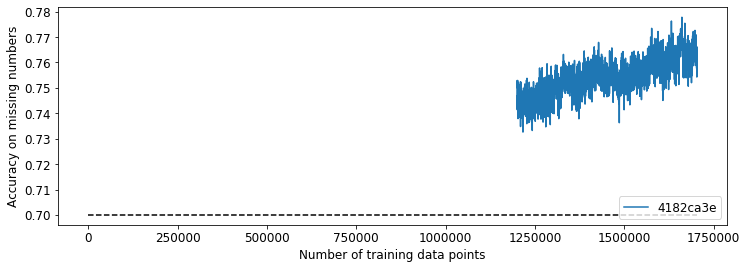

In [16]:
fg, ax = plt.subplots(figsize=(12, 4))
ax.plot(df["datapoint"], df["accuracy_mv"], label=UNIQUE_ID)
ax.hlines(0.7, 0, df["datapoint"].max(), linestyle='--')
ax.legend(loc="lower right")
ax.set_xlabel("Number of training data points")
ax.set_ylabel("Accuracy on missing numbers")

## Load model

In [17]:
%run sudoku_train/{UNIQUE_ID}/model.py

<Figure size 432x288 with 0 Axes>

In [18]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [19]:
state_files = sorted(
    Path("sudoku_train").joinpath(UNIQUE_ID).glob("*.state"),
    key=lambda s: int(s.name.split("-")[2].strip("d")),
)

state_files

[PosixPath('sudoku_train/4182ca3e/e0-s16667-d100002-amv06422.state'),
 PosixPath('sudoku_train/4182ca3e/e0-s33334-d200004-amv06579.state'),
 PosixPath('sudoku_train/4182ca3e/e0-s50000-d300000-amv06785.state'),
 PosixPath('sudoku_train/4182ca3e/e0-s66667-d400002-amv07025.state'),
 PosixPath('sudoku_train/4182ca3e/e0-s83334-d500004-amv07019.state'),
 PosixPath('sudoku_train/4182ca3e/e0-s100000-d600000-amv07148.state'),
 PosixPath('sudoku_train/4182ca3e/e0-s116667-d700002-amv07266.state'),
 PosixPath('sudoku_train/4182ca3e/e0-s133334-d800004-amv07228.state'),
 PosixPath('sudoku_train/4182ca3e/e0-s150000-d900000-amv07303.state'),
 PosixPath('sudoku_train/4182ca3e/e0-s166667-d1000002-amv07268.state'),
 PosixPath('sudoku_train/4182ca3e/e0-s183334-d1100004-amv07353.state'),
 PosixPath('sudoku_train/4182ca3e/e0-s200000-d1200000-amv07444.state'),
 PosixPath('sudoku_train/4182ca3e/e0-s216667-d1300002-amv07436.state'),
 PosixPath('sudoku_train/4182ca3e/e0-s233334-d1400004-amv07604.state'),
 Posix

In [20]:
state_file = state_files[-1]
state_file

PosixPath('sudoku_train/4182ca3e/e0-s283334-d1700004-amv07615.state')

In [21]:
net = Net(
    x_input_size=13, adj_input_size=3, hidden_size=162, output_size=9, batch_size=8
).to(device)

net.load_state_dict(torch.load(state_file))
net.eval()
net = net.to(device)

## Test plots

### Oneshot

In [22]:
datasets["sudoku_valid_0"].reset()
edge_attr = datasets["sudoku_valid_0"][0].edge_attr.to(device)

In [23]:
results = []
for data in datasets["sudoku_test"]:
    data = data.to(device)
    is_missing = data.x == 9
    output = net(data.x, data.edge_index, edge_attr)
    output = torch.softmax(output, dim=1)
    _, predicted = output.max(dim=1)
    num_correct = float((predicted[is_missing] == data.y[is_missing]).sum())
    num_total = float(is_missing.sum())
    results.append({"fraction_correct": num_correct / num_total, "num_correct": num_correct, "num_total": num_total})
oneshot_results_df = pd.DataFrame(results)

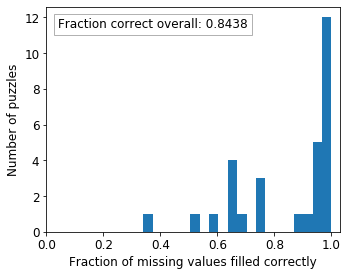

In [24]:
xlim = (0, 1.03)
textstr = """\
Fraction correct overall: {:.4f}
""".format(
    oneshot_results_df["num_correct"].sum() / oneshot_results_df["num_total"].sum()
).strip()
props = dict(facecolor="white", alpha=0.3)

fg, ax = plt.subplots(figsize=(5, 4))
data = oneshot_results_df["fraction_correct"]
assert data.min() >= xlim[0] and data.max() <= xlim[1]
ax.hist(data, bins=20)
ax.set_ylabel("Number of puzzles")
ax.set_xlabel("Fraction of missing values filled correctly")
ax.set_xlim(*xlim)
#     ax.set_ylim(0, 5)
# ax.set_title("Test - Oneshot")
ax.text(0.04, 0.95, textstr, transform=ax.transAxes, fontsize="medium", verticalalignment="top", bbox=props)
fg.tight_layout()
fg.savefig(NOTEBOOK_PATH / "test-oneshot.svg")
fg.savefig(NOTEBOOK_PATH / "test-oneshot.pdf")
fg.savefig(NOTEBOOK_PATH / "test-oneshot.png", dpi=300)

In [25]:
# 0.8546 (94adb904)

### Incremental

In [26]:
@torch.no_grad()
def design_sudoku(net, x, edge_index, edge_attr, log_conf_lst=None):
    mask = (x == 9)
    if not mask.any():
        return x
    
    index_array = torch.arange(x.size(0))
    
    output = net(x, edge_index, edge_attr)
    output = output[mask]
    index_array = index_array[mask]

    max_pred, max_index = torch.softmax(output, dim=1).max(dim=1)

    _, max_residue = max_pred.max(dim=0)
    if log_conf_lst is not None:
        log_conf_lst.append(torch.log(max_pred[max_residue]).data.cpu())

    assert x[index_array[max_residue]] == 9
    x[index_array[max_residue]] = max_index[max_residue]
    return design_sudoku(net, x, edge_index, edge_attr, log_conf_lst)

In [27]:
wrong_preds = []
results = []
for data in tqdm.tqdm_notebook(datasets["sudoku_test"], total=len(datasets["sudoku_test"])):
    data = data.to(device)
    x_in = data.x.clone()
    is_missing = x_in == 9
    log_conf_lst = []
    predicted = design_sudoku(net, x_in, data.edge_index, edge_attr, log_conf_lst)
    num_correct = float((predicted[is_missing] == data.y[is_missing]).sum())
    num_total = float(is_missing.sum())
    results.append(
        {
            "fraction_correct": num_correct / num_total,
            "num_correct": num_correct,
            "num_total": num_total,
            "sum_log_prob": np.sum(log_conf_lst),
        }
    )
    if num_correct < num_total:
        wrong_preds.append(
            (
                data.x.data.cpu().numpy(),
                data.edge_index.data.cpu().numpy(),
                data.y.data.cpu().numpy(),
                predicted.data.cpu().numpy(),
            )
        )
results_df = pd.DataFrame(results)
print(results_df["num_correct"].sum() / results_df["num_total"].sum())


0.9381377551020408


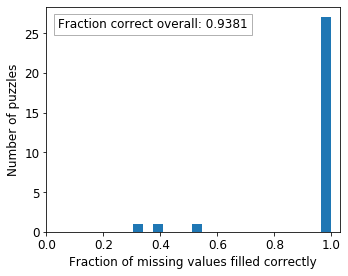

In [28]:
xlim = (0, 1.03)
textstr = """\
Fraction correct overall: {:.4f}
""".format(
    results_df["num_correct"].sum() / results_df["num_total"].sum()
).strip()
props = dict(facecolor="white", alpha=0.3)

fg, ax = plt.subplots(figsize=(5, 4))
data = results_df["fraction_correct"]
assert data.min() >= xlim[0] and data.max() <= xlim[1]
ax.hist(data, bins=20)
ax.set_ylabel("Number of puzzles")
ax.set_xlabel("Fraction of missing values filled correctly")
ax.set_xlim(*xlim)
#     ax.set_ylim(0, 5)
# ax.set_title("Test - Incremental")
ax.text(0.04, 0.95, textstr, transform=ax.transAxes, fontsize="medium", verticalalignment="top", bbox=props)
fg.tight_layout()
fg.savefig(NOTEBOOK_PATH / "test-incremental.svg", bbox_inches="tight")
fg.savefig(NOTEBOOK_PATH / "test-incremental.pdf", bbox_inches="tight")
fg.savefig(NOTEBOOK_PATH / "test-incremental.png", dpi=300, bbox_inches="tight")

In [29]:
# 0.9534 (94adb904)

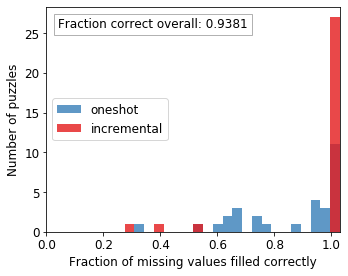

In [30]:
xlim = (0, 1.03)
textstr = """\
Fraction correct overall: {:.4f}
""".format(
    results_df["num_correct"].sum() / results_df["num_total"].sum()
).strip()
props = dict(facecolor="white", alpha=0.3)


fg, ax = plt.subplots(figsize=(5, 4))

data = oneshot_results_df["fraction_correct"]
assert data.min() >= xlim[0] and data.max() <= xlim[1]
ax.hist(data, bins=30, range=xlim, alpha=0.8, label="oneshot", color=cm.get_cmap("Set1")(1))

data = results_df["fraction_correct"]
assert data.min() >= xlim[0] and data.max() <= xlim[1]
ax.hist(data, bins=30, range=xlim, alpha=0.8, label="incremental", color=cm.get_cmap("Set1")(0))

ax.set_ylabel("Number of puzzles")
ax.set_xlabel("Fraction of missing values filled correctly")
ax.set_xlim(*xlim)
ax.legend(loc="center left")
#     ax.set_ylim(0, 5)
# ax.set_title("Test - Incremental")
ax.text(0.04, 0.95, textstr, transform=ax.transAxes, fontsize="medium", verticalalignment="top", bbox=props)
fg.tight_layout()
fg.savefig(NOTEBOOK_PATH / "test-oneshot_incremental.svg", bbox_inches="tight")
fg.savefig(NOTEBOOK_PATH / "test-oneshot_incremental.pdf", bbox_inches="tight")
fg.savefig(NOTEBOOK_PATH / "test-oneshot_incremental.png", dpi=300, bbox_inches="tight")

In [31]:
raise Exception(UNIQUE_ID)

Exception: 4182ca3e

## Validation plots

### Oneshot

In [ ]:
results = []

datasets["sudoku_valid_0"].reset()
for i, data in tqdm.tqdm_notebook(
    enumerate(
        DataLoader(
            datasets["sudoku_valid_0"],
            shuffle=False,
            num_workers=1,
            batch_size=1,
            drop_last=False,
        )
    ),
    total=1001,
):
    if i >= 1000:
        break
    data = data.to(device)
    is_missing = data.x == 9
    output = net(data.x, data.edge_index, data.edge_attr)
    output = torch.softmax(output, dim=1)
    _, predicted = output.max(dim=1)
    num_correct = float((predicted[is_missing] == data.y[is_missing]).sum())
    num_total = float(is_missing.sum())
    results.append(
        {
            "fraction_correct": num_correct / num_total,
            "num_correct": num_correct,
            "num_total": num_total,
        }
    )
results_df = pd.DataFrame(results)

In [ ]:
xlim = (0.0, 1.03)
textstr = """\
Fraction correct overall: {:.4f}
""".format(
    results_df["num_correct"].sum() / results_df["num_total"].sum()
).strip()
props = dict(facecolor="white", alpha=0.3)

with plt.rc_context(rc={"font.size": 12}):
    fg, ax = plt.subplots(figsize=(6, 4))
    data = results_df["fraction_correct"]
    assert data.min() >= xlim[0] and data.max() <= xlim[1]
    ax.hist(data)
    ax.set_ylabel("Number of puzzles")
    ax.set_xlabel("Fraction of missing values filled correctly")
    ax.set_xlim(*xlim)
    #     ax.set_ylim(0, 5)
    ax.set_title("Validation - Oneshot")
    ax.text(0.04, 0.95, textstr, transform=ax.transAxes, fontsize="medium", verticalalignment="top", bbox=props)
fg.savefig(NOTEBOOK_PATH / "validation-oneshot.svg")
fg.savefig(NOTEBOOK_PATH / "validation-oneshot.pdf")
fg.savefig(NOTEBOOK_PATH / "validation-oneshot.png", dpi=300)

### Incremental

In [ ]:
@torch.no_grad()
def design_sudoku(net, x, edge_index, edge_attr):
    mask = (x == 9)
    if not mask.any():
        return x
    output = net(x, edge_index, edge_attr)
    output = torch.softmax(output, dim=1)
    max_pred, max_index = output.max(dim=1)
    max_pred[~mask] = -1
    _, max_residue = max_pred.max(dim=0)
    x[max_residue] = max_index[max_residue]
    return design_sudoku(net, x, edge_index, edge_attr)

In [ ]:
results = []

datasets["sudoku_valid_0"].reset()
for i, data in tqdm.tqdm_notebook(
    enumerate(
        DataLoader(
            datasets["sudoku_valid_0"],
            shuffle=False,
            num_workers=1,
            batch_size=1,
            drop_last=False,
        )
    ),
    total=10,
):
    if i >= 10:
        break
    data = data.to(device)
    x_in = data.x.clone()
    is_missing = x_in == 9
    predicted = design_sudoku(net, x_in, data.edge_index, data.edge_attr)
    num_correct = float((predicted[is_missing] == data.y[is_missing]).sum())
    num_total = float(is_missing.sum())
    results.append({"fraction_correct": num_correct / num_total, "num_correct": num_correct, "num_total": num_total})
results_df = pd.DataFrame(results)

In [ ]:
xlim = (0.0, 1.03)
textstr = """\
Fraction correct overall: {:.4f}
""".format(
    results_df["num_correct"].sum() / results_df["num_total"].sum()
).strip()
props = dict(facecolor="white", alpha=0.3)

with plt.rc_context(rc={"font.size": 12}):
    fg, ax = plt.subplots(figsize=(6, 4))
    data = results_df["fraction_correct"]
    assert data.min() >= xlim[0] and data.max() <= xlim[1]
    ax.hist(data, bins=20)
    ax.set_ylabel("Number of puzzles")
    ax.set_xlabel("Fraction of missing values filled correctly")
    ax.set_xlim(*xlim)
#     ax.set_ylim(0, 5)
    ax.set_title("Validation - Incremental")
    ax.text(0.04, 0.95, textstr, transform=ax.transAxes, fontsize="medium", verticalalignment="top", bbox=props)
fg.savefig(NOTEBOOK_PATH / "validation-incremental.svg")
fg.savefig(NOTEBOOK_PATH / "validation-incremental.pdf")
fg.savefig(NOTEBOOK_PATH / "validation-incremental.png", dpi=300)

In [ ]:
raise Exception("Done!")

In [ ]:
sdf

In [ ]:
import torch_geometric
torch_geometric.utils.sparse_to_dense(torch.tensor(wrong_preds[0][1]))

In [ ]:
mpl.rcParams.update({"font.size": 12})

fg, ax = plt.subplots(figsize=(5.5, 4))
ax.imshow(torch_geometric.utils.sparse_to_dense(torch.tensor(wrong_preds[0][1])), cmap="Greys")
# ax.colorbar()
ax.set_xlabel("Number position")
ax.set_ylabel("Number position")
fg.tight_layout()
fg.savefig(NOTEBOOK_PATH.joinpath("sudoku_adjacency.svg"), bbox_inches="tight")
fg.savefig(NOTEBOOK_PATH.joinpath("sudoku_adjacency.pdf"), bbox_inches="tight")
fg.savefig(NOTEBOOK_PATH.joinpath("sudoku_adjacency.png"), bbox_inches="tight", dpi=300)

In [ ]:
def plot_sudoku(puzzle, solved=None, pred=None, ax=None):
    # Simple plotting statement that ingests a 9x9 array (n), and plots a sudoku-style grid around it.
    if ax is None:
        _, ax = plt.subplots()

    for y in range(10):
        ax.plot([-0.05, 9.05], [y, y], color="black", linewidth=1)

    for y in range(0, 10, 3):
        ax.plot([-0.05, 9.05], [y, y], color="black", linewidth=3)

    for x in range(10):
        ax.plot([x, x], [-0.05, 9.05], color="black", linewidth=1)

    for x in range(0, 10, 3):
        ax.plot([x, x], [-0.05, 9.05], color="black", linewidth=3)

    ax.axis("image")
    ax.axis("off")  # drop the axes, they're not important here

    for x in range(9):
        for y in range(9):
            puzzle_element = puzzle[8 - y][x]  # need to reverse the y-direction for plotting
            if puzzle_element > 0:  # ignore the zeros
                T = f"{puzzle_element}"
                ax.text(x + 0.3, y + 0.2, T, fontsize=20)
            elif solved is not None and pred is not None:
                solved_element = solved[8 - y][x]
                pred_element = pred[8 - y][x]
                if solved_element == pred_element:
                    T = f"{solved_element}"
                    ax.text(x + 0.3, y + 0.2, T, fontsize=20, color="b")
                else:
                    ax.text(x + 0.1, y + 0.3, f"{pred_element}", fontsize=13, color="r")
                    ax.text(x + 0.55, y + 0.3, f"{solved_element}", fontsize=13, color="g")

In [ ]:
error_index = 0

mpl.rcParams.update({"font.size": 12})

fg, ax = plt.subplots(figsize=(5.5, 4))
row = wrong_preds[error_index]
puzzle = np.where(row[0] < 9, row[0] + 1, 0).reshape(9, 9)
solution = np.where(row[2] < 9, row[2] + 1, 0).reshape(9, 9)
pred = np.where(row[3] < 9, row[3] + 1, 0).reshape(9, 9)
plot_sudoku(puzzle, solution, pred, ax=ax)
fg.tight_layout()
fg.savefig(NOTEBOOK_PATH.joinpath(f"sudoku_error_{error_index}.svg"), bbox_inches="tight")
fg.savefig(NOTEBOOK_PATH.joinpath(f"sudoku_error_{error_index}.svg"), bbox_inches="tight")
fg.savefig(NOTEBOOK_PATH.joinpath(f"sudoku_error_{error_index}.png"), bbox_inches="tight", dpi=300)

In [ ]:
xlim = (0, 1.03)

fg, ax = plt.subplots(figsize=(6, 4))
ax.plot(results_df["fraction_correct"], results_df["sum_log_prob"], 'r.')
ax.set_xlabel("Fraction of residues correct")
ax.set_ylabel("Sum of log-probabilities")
ax.set_xlim(*xlim)
fg.savefig(NOTEBOOK_PATH / "test-incremental-probas.svg")
fg.savefig(NOTEBOOK_PATH / "test-incremental-probas.pdf")
fg.savefig(NOTEBOOK_PATH / "test-incremental-probas.png", dpi=300)

In [ ]:
for file in sorted(Path("sudoku_4xEdgeConv_stretch").glob("*.state")):
    print(file)
    net = Net(x_input_size=10, adj_input_size=None, hidden_size=128, output_size=9)
    # net.load_state_dict(torch.load("sudoku_4xEdgeConv_stretch/e0-s7812-d999936-amv09791666666666666.state"))
    net.load_state_dict(torch.load(file))

    net.eval()
    net = net.to(device)

    results = []
    for data in sudoku_dataset_test:
        data = data.to(device)
        x_in = data.x.clone()
        is_missing = x_in == 9
        log_conf_lst = []
        predicted = design_sudoku(net, x_in, data.edge_index, log_conf_lst)
        num_correct = float((predicted[is_missing] == data.y[is_missing]).sum())
        num_total = float(is_missing.sum())
        results.append(
            {
                "fraction_correct": num_correct / num_total,
                "num_correct": num_correct,
                "num_total": num_total,
                "sum_log_prob": np.sum(log_conf_lst),
            }
        )
    results_df = pd.DataFrame(results)
    print(results_df["num_correct"].sum() / results_df["num_total"].sum())

In [ ]:
raise Exception

In [ ]:
@torch.no_grad()
def design_sudoku_2(net, x, x_proba, edge_index, cutoff=-1):
    if x_proba is None:
        x_proba = torch.zeros_like(x).to(torch.float)

    mask = (x == 9)
    if not mask.any():
        return [(x, x_proba)]

    index_array = torch.arange(x.size(0))
    
    output = net(x, edge_index)
    output = torch.softmax(output, dim=1)
    output = output[mask]
    index_array = index_array[mask]

    max_index = output.max(dim=1)[0].max(dim=0)[1]
    max_pred_row = output[max_index]

    sum_log_prob = x_proba.sum()
    assert sum_log_prob.item() <= 0, x_proba

    p_cutoff = min(torch.exp(cutoff - sum_log_prob), max_pred_row.max()).item()
    results = []
    for i, p in enumerate(max_pred_row):
        if p < p_cutoff:
            continue
        x_clone = x.clone()
        x_proba_clone = x_proba.clone()
        assert x_clone[index_array[max_index]] == 9
        x_clone[index_array[max_index]] = i
        x_proba_clone[index_array[max_index]] = torch.log(p)
        result = design_sudoku_2(net, x_clone, x_proba_clone, edge_index)
        results.extend(result)
    return results

In [ ]:
data = sudoku_dataset_test[0].to(device)

In [ ]:
results = design_sudoku_2(net, data.x.clone(), None, data.edge_index)

In [ ]:
results = sorted(((a.data.cpu(), b.data.cpu()) for a, b in results), reverse=True)

In [ ]:
results = []
for data in sudoku_dataset_test:
    data = data.to(device)
    is_missing = data.x == 9
    outputs = design_sudoku_2(net, data.x.clone(), None, data.edge_index, -20)
    outputs = sorted((t for t in outputs), key=lambda t: t[1].sum().item(), reverse=True)
#     results = sorted(((a.data.cpu(), b.data.cpu()) for a, b in results), reverse=True)
    y, y_proba = outputs[0]
    num_correct = float((y[is_missing] == data.y[is_missing]).sum())
    num_total = float(is_missing.sum())
    results.append(
        {
            "fraction_correct": num_correct / num_total,
            "num_correct": num_correct,
            "num_total": num_total,
            "sum_log_prob": torch.sum(y_proba).cpu().item(),
        }
    )
results_df = pd.DataFrame(results)

In [ ]:
xlim = (0, 1.03)

with plt.rc_context(rc={"font.size": 12}):
    fg, ax = plt.subplots(figsize=(6, 4))
    ax.plot(results_df["fraction_correct"], results_df["sum_log_prob"], 'r.')
    ax.set_xlabel("Fraction of residues correct")
    ax.set_ylabel("Sum of log-probabilities")
    ax.set_xlim(*xlim)

In [ ]:
xlim = (0, 1.03)
textstr = """\
Fraction correct overall: {:.4f}
""".format(
    results_df["num_correct"].sum() / results_df["num_total"].sum()
).strip()
props = dict(facecolor="white", alpha=0.3)

with plt.rc_context(rc={"font.size": 12}):
    fg, ax = plt.subplots(figsize=(6, 4))
    data = results_df["fraction_correct"]
    assert data.min() >= xlim[0] and data.max() <= xlim[1]
    ax.hist(data, bins=20)
    ax.set_ylabel("Number of puzzles")
    ax.set_xlabel("Fraction of missing values filled correctly")
    ax.set_xlim(*xlim)
#     ax.set_ylim(0, 5)
    ax.set_title("Test - Incremental")
    ax.text(0.04, 0.95, textstr, transform=ax.transAxes, fontsize="medium", verticalalignment="top", bbox=props)

In [ ]:
@torch.no_grad()
def design_sudoku_3(net, x, x_proba, edge_index, cutoff=-1):
    if x_proba is None:
        x_proba = torch.zeros_like(x).to(torch.float)
    sum_log_prob = x_proba.sum()

    mask = (x == 9)
    if not mask.any():
        return [(x, x_proba)]

    index_array = torch.arange(x.size(0))
    
    output = net(x, edge_index)
    output = output[mask]
    index_array = index_array[mask]

    # Select rows to examine
    output_sum = output.sum(dim=1)
    row_probas = torch.softmax(output_sum, dim=0)
    row_proba_cutoff = min(0.1, row_probas.max())
    index_array_2 = torch.arange(len(row_probas))[row_probas >= row_proba_cutoff][:3]
    
    output = output[index_array_2]
    index_array = index_array[index_array_2]
    
    # Select columns to examine
    output = torch.softmax(output, dim=1)
    
    results = []
    for i, row in enumerate(output):
        p_cutoff = min(torch.exp(cutoff - sum_log_prob), row.max()).item()
        for j, p in enumerate(row):
            if p < p_cutoff:
                continue
            x_clone = x.clone()
            x_proba_clone = x_proba.clone()
            assert x_clone[index_array[i]] == 9
            x_clone[index_array[i]] = i
            x_proba_clone[index_array[i]] = torch.log(p)
            result = design_sudoku_3(net, x_clone, x_proba_clone, edge_index)
            results.extend(result)
    return results

In [ ]:
data = sudoku_dataset_test[0].to(device)

In [ ]:
# results = design_sudoku_3(net, data.x.clone(), None, data.edge_index, -5)

In [ ]:
# results = sorted(((a.data.cpu(), b.data.cpu()) for a, b in results), reverse=True)

In [ ]:
x = torch.arange(4)
x[torch.tensor([0, 0, 0, 1], dtype=torch.uint8)] = 10
x

In [ ]:
torch.tensor([1,2,3], dtype=torch)